# Predictive Maintenance: Machine Remaining Useful Life (RUL) Prediction

## Project Overview

This notebook implements a comprehensive predictive maintenance system that predicts the Remaining Useful Life (RUL) of machines based on sensor data and maintenance records. The system analyzes hourly sensor readings to determine machine condition and estimates failure probability, which is then converted to RUL percentage.

### Key Features:
- **Multi-sensor Analysis**: Processes data from multiple sensors attached to machines
- **Maintenance Integration**: Uses maintenance records as additional hints for failure detection
- **Model Comparison**: Compares multiple approaches including Hugging Face pre-trained models
- **RUL Calculation**: Converts failure probability to actionable RUL percentages


---

## 1. Environment Setup and Library Installation

### Installing Required Libraries

In [2]:
# Core data science libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                           roc_curve, precision_recall_curve, f1_score, accuracy_score)

# Deep learning and time series
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Hugging Face transformers
from transformers import AutoTokenizer, AutoModel, pipeline
import torch

# Visualization
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Utility libraries
import datetime
from datetime import timedelta
import os
import gc

print("All libraries imported successfully!")


All libraries imported successfully!


### Setting up Configuration and Constants

In [3]:
# Configuration settings
CONFIG = {
    'random_state': 42,
    'test_size': 0.2,
    'validation_size': 0.2,
    'n_estimators': 100,
    'lstm_units': 50,
    'epochs': 50,
    'batch_size': 32,
    'learning_rate': 0.001,
    'sequence_length': 24,  # 24 hours lookback
    'threshold_probability': 0.5
}

# Set random seeds for reproducibility
np.random.seed(CONFIG['random_state'])
tf.random.set_seed(CONFIG['random_state'])

# Display settings
plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("Configuration set successfully!")


Configuration set successfully!


---

## 2. Data Loading and Initial Exploration

### Loading the Dataset

In [4]:
# Load the dataset files
# The Microsoft Azure Predictive Maintenance dataset contains multiple CSV files
data_path = '/kaggle/input/microsoft-azure-predictive-maintenance/'

# Load all CSV files
telemetry_df = pd.read_csv(f'{data_path}PdM_telemetry.csv')
maintenance_df = pd.read_csv(f'{data_path}PdM_maint.csv')
failures_df = pd.read_csv(f'{data_path}PdM_failures.csv')
machines_df = pd.read_csv(f'{data_path}PdM_machines.csv')
errors_df = pd.read_csv(f'{data_path}PdM_errors.csv')

print("Dataset loaded successfully!")
print(f"Telemetry data shape: {telemetry_df.shape}")
print(f"Maintenance data shape: {maintenance_df.shape}")
print(f"Failures data shape: {failures_df.shape}")
print(f"Machines data shape: {machines_df.shape}")
print(f"Errors data shape: {errors_df.shape}")


Dataset loaded successfully!
Telemetry data shape: (876100, 6)
Maintenance data shape: (3286, 3)
Failures data shape: (761, 3)
Machines data shape: (100, 3)
Errors data shape: (3919, 3)


### Dataset Overview and Structure Analysis

In [5]:
# Display basic information about each dataset
datasets = {
    'Telemetry': telemetry_df,
    'Maintenance': maintenance_df,
    'Failures': failures_df,
    'Machines': machines_df,
    'Errors': errors_df
}

for name, df in datasets.items():
    print(f"\n{'='*50}")
    print(f"{name} Dataset Overview")
    print(f"{'='*50}")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print(f"Data Types:\n{df.dtypes}")
    print(f"Missing Values:\n{df.isnull().sum()}")
    print(f"Sample Data:\n{df.head()}")



Telemetry Dataset Overview
Shape: (876100, 6)
Columns: ['datetime', 'machineID', 'volt', 'rotate', 'pressure', 'vibration']
Data Types:
datetime      object
machineID      int64
volt         float64
rotate       float64
pressure     float64
vibration    float64
dtype: object
Missing Values:
datetime     0
machineID    0
volt         0
rotate       0
pressure     0
vibration    0
dtype: int64
Sample Data:
              datetime  machineID        volt      rotate    pressure  \
0  2015-01-01 06:00:00          1  176.217853  418.504078  113.077935   
1  2015-01-01 07:00:00          1  162.879223  402.747490   95.460525   
2  2015-01-01 08:00:00          1  170.989902  527.349825   75.237905   
3  2015-01-01 09:00:00          1  162.462833  346.149335  109.248561   
4  2015-01-01 10:00:00          1  157.610021  435.376873  111.886648   

   vibration  
0  45.087686  
1  43.413973  
2  34.178847  
3  41.122144  
4  25.990511  

Maintenance Dataset Overview
Shape: (3286, 3)
Columns: ['date

---

## 3. Exploratory Data Analysis (EDA)

### Temporal Patterns Analysis

In [6]:
# Convert datetime columns to proper datetime format
telemetry_df['datetime'] = pd.to_datetime(telemetry_df['datetime'])
maintenance_df['datetime'] = pd.to_datetime(maintenance_df['datetime'])
failures_df['datetime'] = pd.to_datetime(failures_df['datetime'])
errors_df['datetime'] = pd.to_datetime(errors_df['datetime'])

# Analyze time range of the dataset
print("Dataset Time Range Analysis:")
print(f"Telemetry: {telemetry_df['datetime'].min()} to {telemetry_df['datetime'].max()}")
print(f"Maintenance: {maintenance_df['datetime'].min()} to {maintenance_df['datetime'].max()}")
print(f"Failures: {failures_df['datetime'].min()} to {failures_df['datetime'].max()}")
print(f"Errors: {errors_df['datetime'].min()} to {errors_df['datetime'].max()}")

# Calculate dataset duration
total_days = (telemetry_df['datetime'].max() - telemetry_df['datetime'].min()).days
print(f"\nTotal monitoring period: {total_days} days")


Dataset Time Range Analysis:
Telemetry: 2015-01-01 06:00:00 to 2016-01-01 06:00:00
Maintenance: 2014-06-01 06:00:00 to 2016-01-01 06:00:00
Failures: 2015-01-02 03:00:00 to 2015-12-31 06:00:00
Errors: 2015-01-01 06:00:00 to 2016-01-01 05:00:00

Total monitoring period: 365 days


### Sensor Data Statistical Analysis

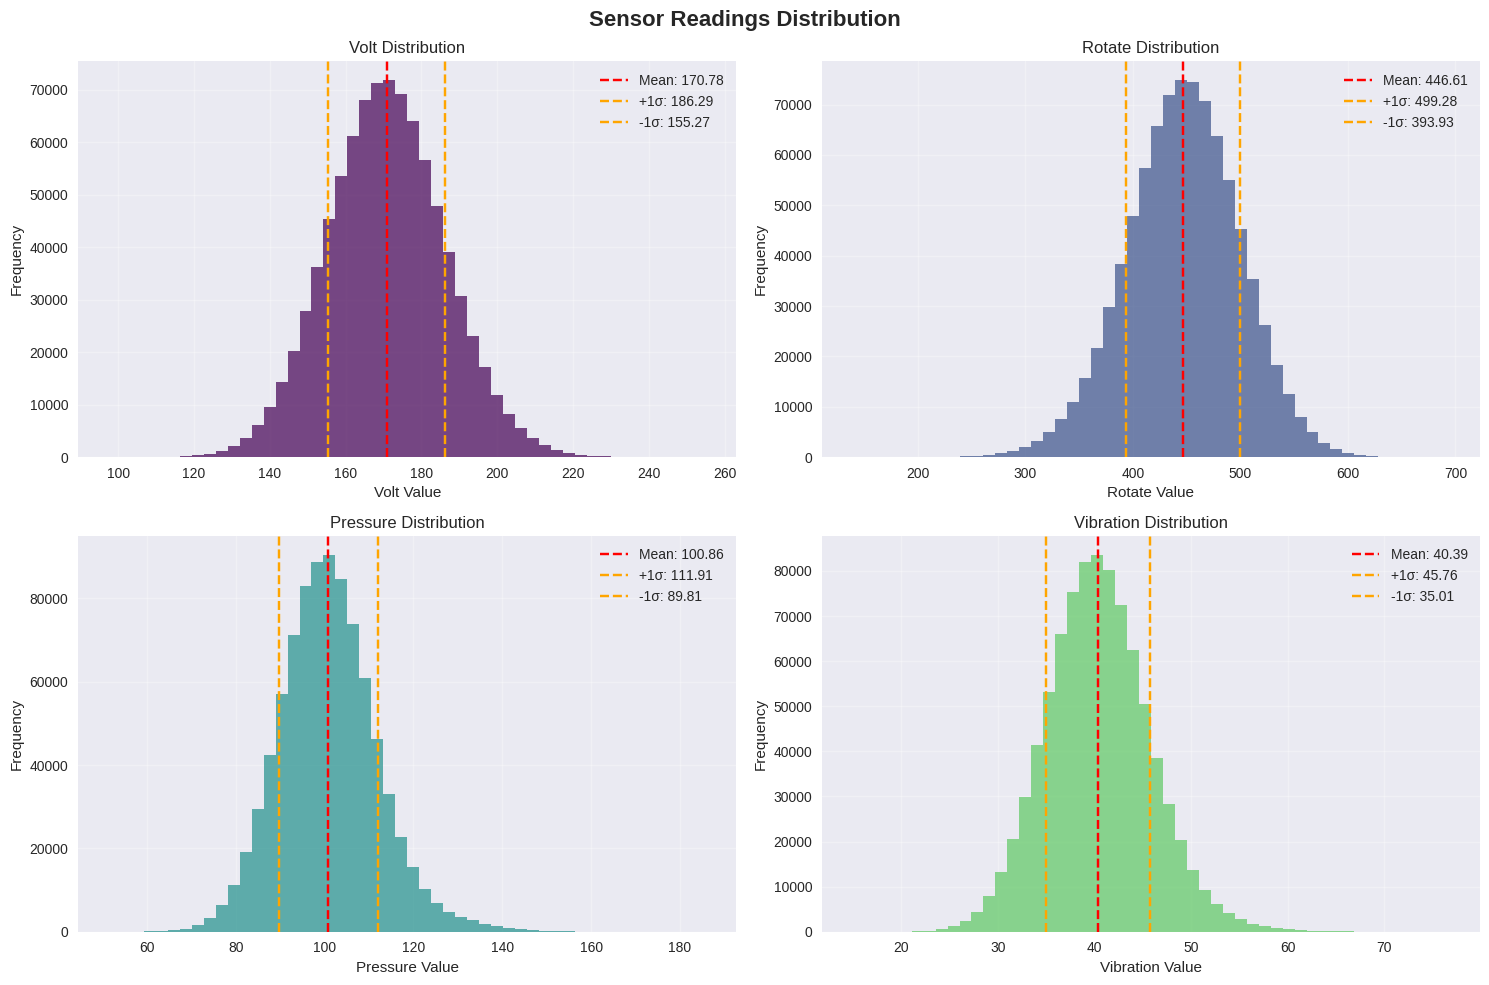


Sensor Data Statistical Summary:
                volt         rotate       pressure      vibration
count  876100.000000  876100.000000  876100.000000  876100.000000
mean      170.777736     446.605119     100.858668      40.385007
std        15.509114      52.673886      11.048679       5.370361
min        97.333604     138.432075      51.237106      14.877054
25%       160.304927     412.305714      93.498181      36.777299
50%       170.607338     447.558150     100.425559      40.237247
75%       181.004493     482.176600     107.555231      43.784938
max       255.124717     695.020984     185.951998      76.791072


In [7]:
# Analyze sensor readings distribution
sensor_columns = ['volt', 'rotate', 'pressure', 'vibration']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Sensor Readings Distribution', fontsize=16, fontweight='bold')

for i, sensor in enumerate(sensor_columns):
    ax = axes[i//2, i%2]
    
    # Histogram
    ax.hist(telemetry_df[sensor], bins=50, alpha=0.7, color=plt.cm.viridis(i/len(sensor_columns)))
    ax.set_title(f'{sensor.capitalize()} Distribution')
    ax.set_xlabel(f'{sensor.capitalize()} Value')
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)
    
    # Add statistics
    mean_val = telemetry_df[sensor].mean()
    std_val = telemetry_df[sensor].std()
    ax.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
    ax.axvline(mean_val + std_val, color='orange', linestyle='--', label=f'+1σ: {mean_val + std_val:.2f}')
    ax.axvline(mean_val - std_val, color='orange', linestyle='--', label=f'-1σ: {mean_val - std_val:.2f}')
    ax.legend()

plt.tight_layout()
plt.show()

# Statistical summary
print("\nSensor Data Statistical Summary:")
print(telemetry_df[sensor_columns].describe())


### Machine and Component Analysis

Machine Characteristics Analysis:
Total number of machines: 100
Machine models: model
model3    35
model4    32
model2    17
model1    16
Name: count, dtype: int64
Machine ages: count    100.000000
mean      11.330000
std        5.856974
min        0.000000
25%        6.750000
50%       12.000000
75%       16.000000
max       20.000000
Name: age, dtype: float64


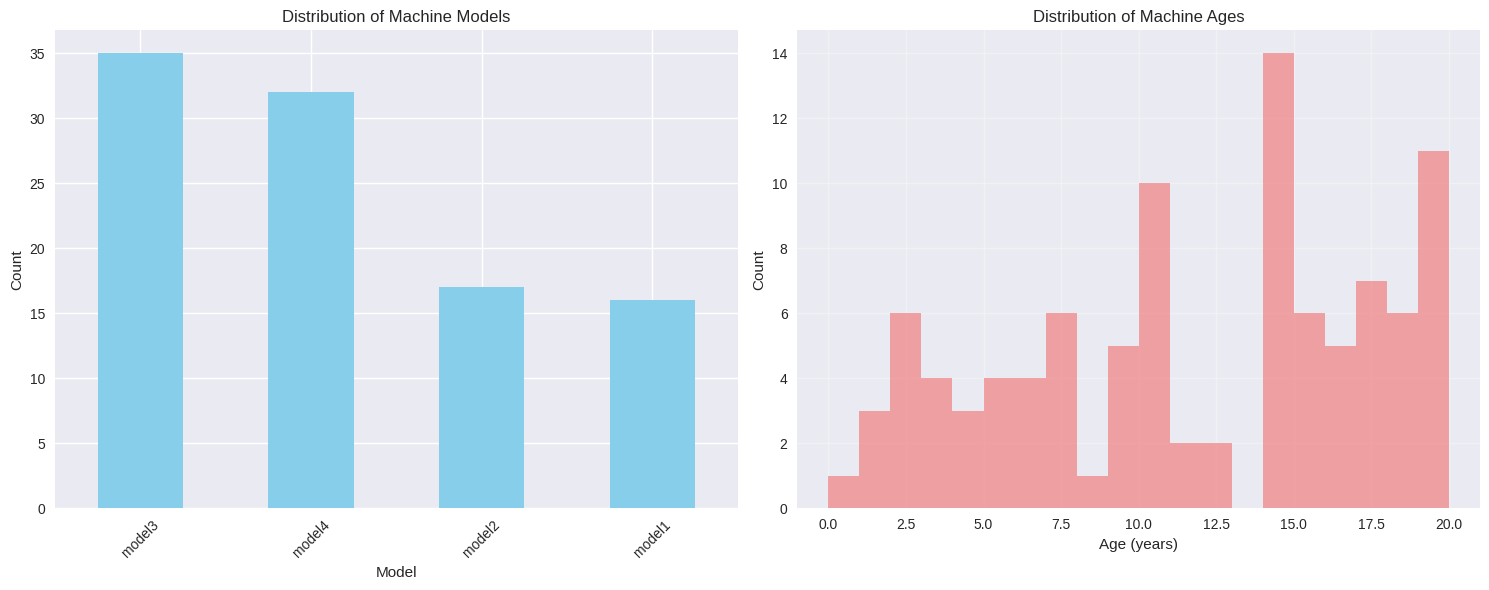

In [8]:
# Analyze machine characteristics
print("Machine Characteristics Analysis:")
print(f"Total number of machines: {machines_df['machineID'].nunique()}")
print(f"Machine models: {machines_df['model'].value_counts()}")
print(f"Machine ages: {machines_df['age'].describe()}")

# Visualize machine distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Machine model distribution
machines_df['model'].value_counts().plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Distribution of Machine Models')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Machine age distribution
axes[1].hist(machines_df['age'], bins=20, color='lightcoral', alpha=0.7)
axes[1].set_title('Distribution of Machine Ages')
axes[1].set_xlabel('Age (years)')
axes[1].set_ylabel('Count')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Maintenance Events Analysis

Maintenance Events Analysis:
Total maintenance events: 3286
Maintenance types: comp
comp2    863
comp4    811
comp3    808
comp1    804
Name: count, dtype: int64
Machines with maintenance: 100

Maintenance per machine statistics:
count    100.000000
mean      32.860000
std        3.168723
min       25.000000
25%       31.000000
50%       33.000000
75%       34.000000
max       39.000000
Name: maintenance_count, dtype: float64


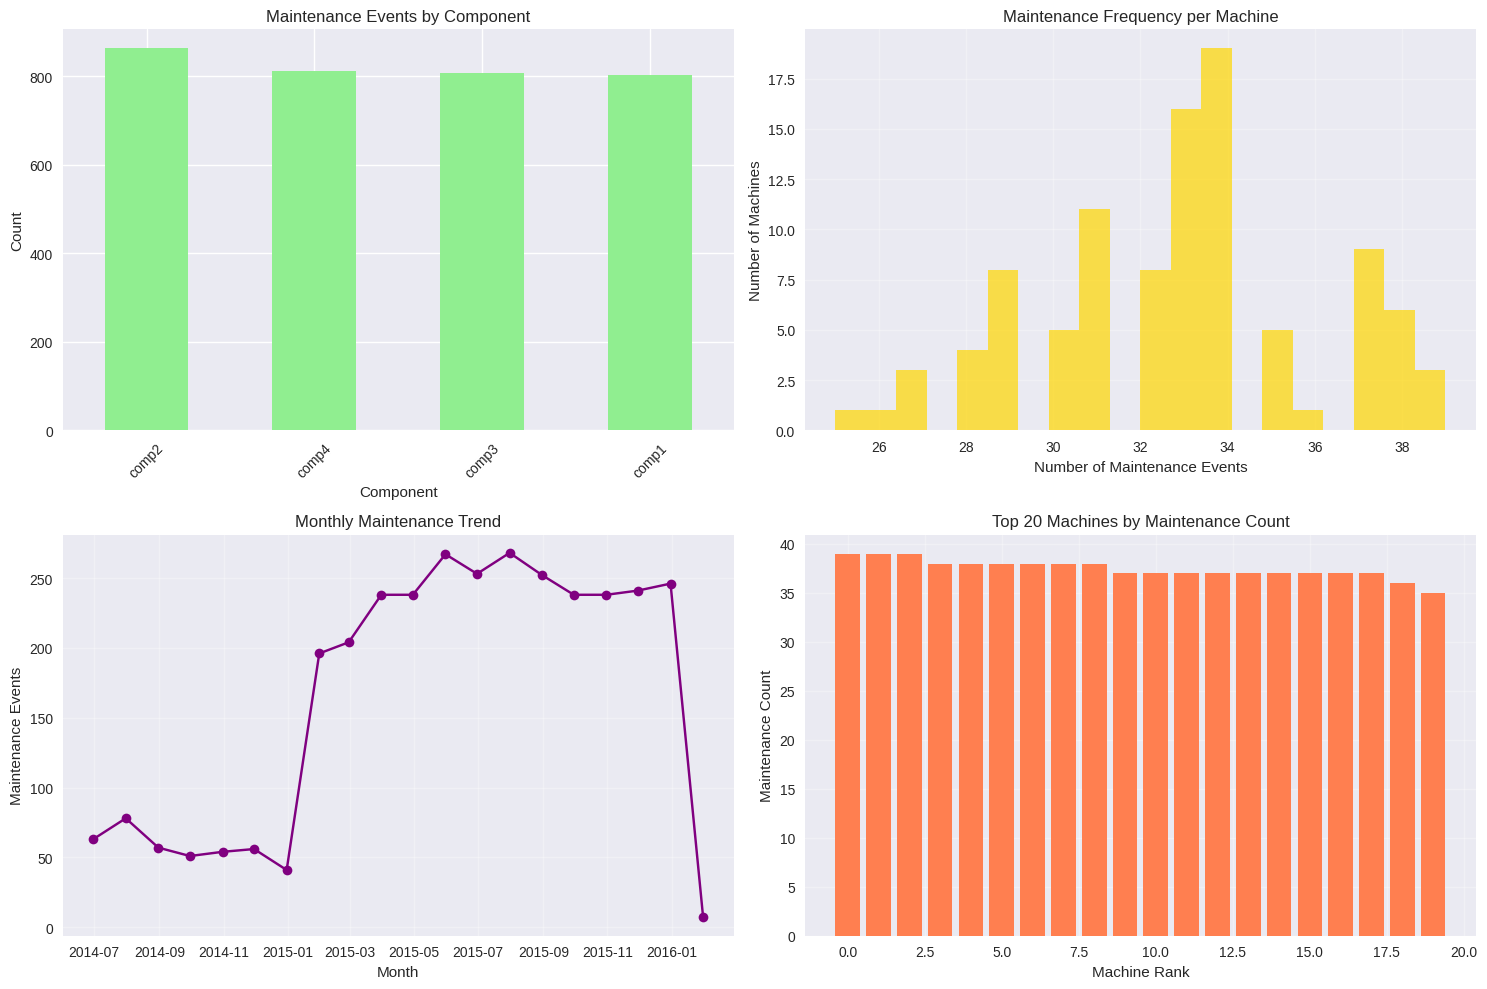

In [9]:
# Analyze maintenance patterns
print("Maintenance Events Analysis:")
print(f"Total maintenance events: {len(maintenance_df)}")
print(f"Maintenance types: {maintenance_df['comp'].value_counts()}")
print(f"Machines with maintenance: {maintenance_df['machineID'].nunique()}")

# Maintenance frequency per machine
maint_per_machine = maintenance_df.groupby('machineID').size().reset_index(name='maintenance_count')
print(f"\nMaintenance per machine statistics:")
print(maint_per_machine['maintenance_count'].describe())

# Visualize maintenance patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Maintenance by component
maintenance_df['comp'].value_counts().plot(kind='bar', ax=axes[0,0], color='lightgreen')
axes[0,0].set_title('Maintenance Events by Component')
axes[0,0].set_xlabel('Component')
axes[0,0].set_ylabel('Count')
axes[0,0].tick_params(axis='x', rotation=45)

# Maintenance frequency per machine
axes[0,1].hist(maint_per_machine['maintenance_count'], bins=20, color='gold', alpha=0.7)
axes[0,1].set_title('Maintenance Frequency per Machine')
axes[0,1].set_xlabel('Number of Maintenance Events')
axes[0,1].set_ylabel('Number of Machines')
axes[0,1].grid(True, alpha=0.3)

# Maintenance timeline
maintenance_monthly = maintenance_df.set_index('datetime').resample('M').size()
axes[1,0].plot(maintenance_monthly.index, maintenance_monthly.values, marker='o', color='purple')
axes[1,0].set_title('Monthly Maintenance Trend')
axes[1,0].set_xlabel('Month')
axes[1,0].set_ylabel('Maintenance Events')
axes[1,0].grid(True, alpha=0.3)

# Maintenance by machine ID (top 20)
top_machines = maintenance_df['machineID'].value_counts().head(20)
axes[1,1].bar(range(len(top_machines)), top_machines.values, color='coral')
axes[1,1].set_title('Top 20 Machines by Maintenance Count')
axes[1,1].set_xlabel('Machine Rank')
axes[1,1].set_ylabel('Maintenance Count')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Failure Events Analysis

Failure Events Analysis:
Total failure events: 761
Failure types: failure
comp2    259
comp1    192
comp4    179
comp3    131
Name: count, dtype: int64
Machines with failures: 98

Failure per machine statistics:
count    98.000000
mean      7.765306
std       3.463509
min       2.000000
25%       5.000000
50%       7.000000
75%      10.000000
max      19.000000
Name: failure_count, dtype: float64


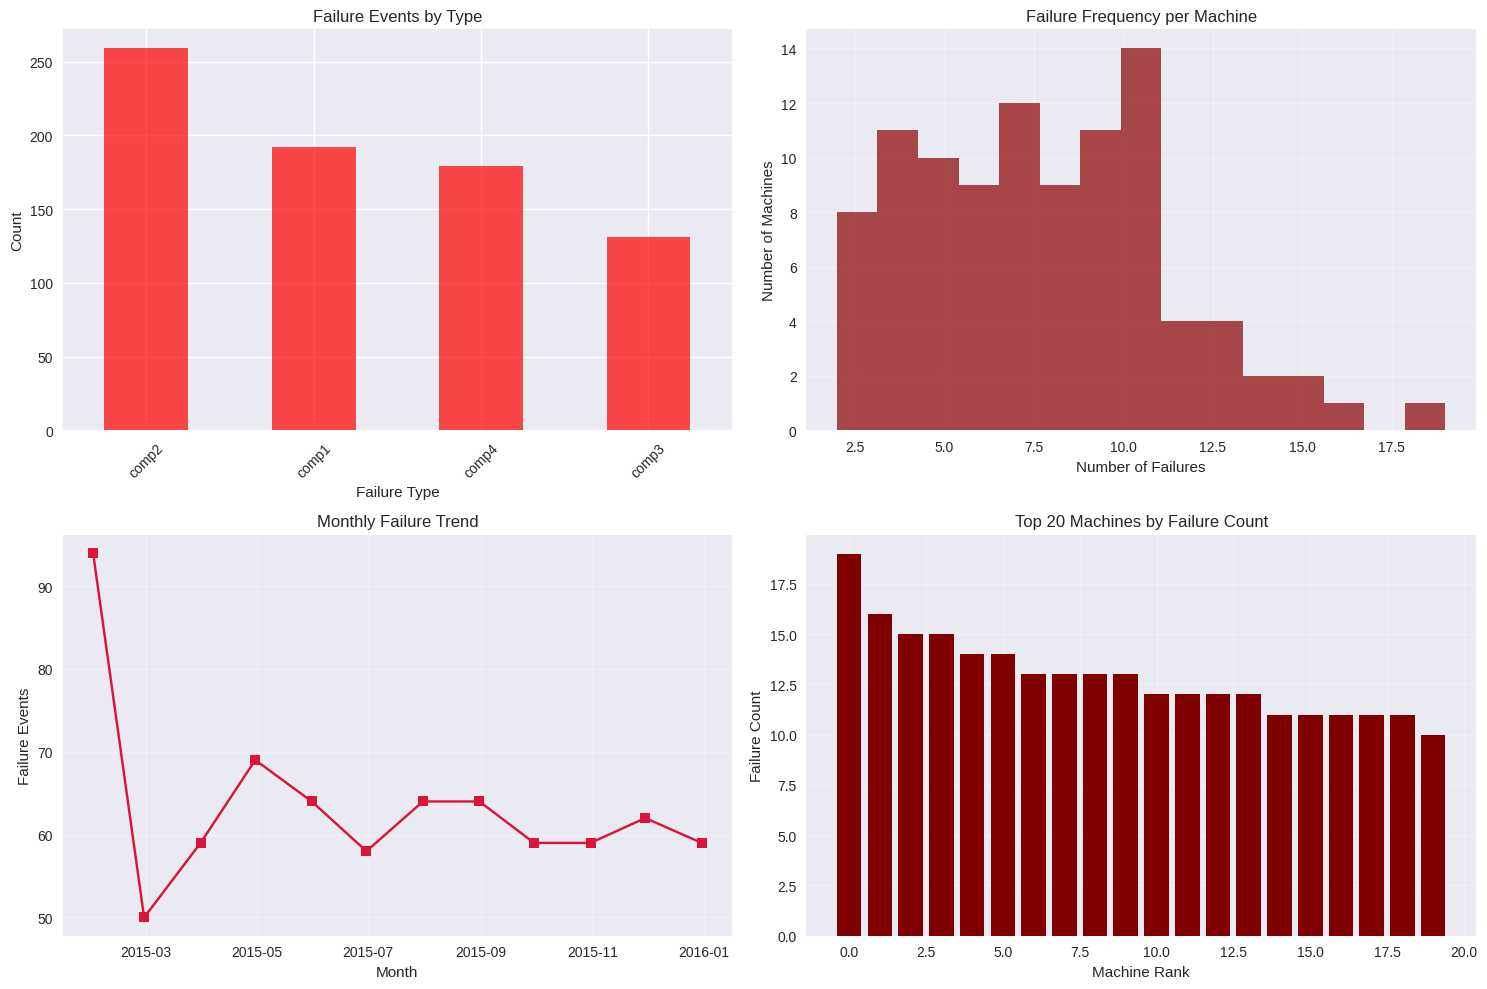

In [10]:
# Analyze failure patterns
print("Failure Events Analysis:")
print(f"Total failure events: {len(failures_df)}")
print(f"Failure types: {failures_df['failure'].value_counts()}")
print(f"Machines with failures: {failures_df['machineID'].nunique()}")

# Failure frequency per machine
failure_per_machine = failures_df.groupby('machineID').size().reset_index(name='failure_count')
print(f"\nFailure per machine statistics:")
print(failure_per_machine['failure_count'].describe())

# Visualize failure patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Failures by type
failures_df['failure'].value_counts().plot(kind='bar', ax=axes[0,0], color='red', alpha=0.7)
axes[0,0].set_title('Failure Events by Type')
axes[0,0].set_xlabel('Failure Type')
axes[0,0].set_ylabel('Count')
axes[0,0].tick_params(axis='x', rotation=45)

# Failure frequency per machine
axes[0,1].hist(failure_per_machine['failure_count'], bins=15, color='darkred', alpha=0.7)
axes[0,1].set_title('Failure Frequency per Machine')
axes[0,1].set_xlabel('Number of Failures')
axes[0,1].set_ylabel('Number of Machines')
axes[0,1].grid(True, alpha=0.3)

# Failure timeline
failure_monthly = failures_df.set_index('datetime').resample('M').size()
axes[1,0].plot(failure_monthly.index, failure_monthly.values, marker='s', color='crimson')
axes[1,0].set_title('Monthly Failure Trend')
axes[1,0].set_xlabel('Month')
axes[1,0].set_ylabel('Failure Events')
axes[1,0].grid(True, alpha=0.3)

# Failures by machine ID (top 20)
top_failure_machines = failures_df['machineID'].value_counts().head(20)
axes[1,1].bar(range(len(top_failure_machines)), top_failure_machines.values, color='maroon')
axes[1,1].set_title('Top 20 Machines by Failure Count')
axes[1,1].set_xlabel('Machine Rank')
axes[1,1].set_ylabel('Failure Count')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Correlation Analysis Between Sensors

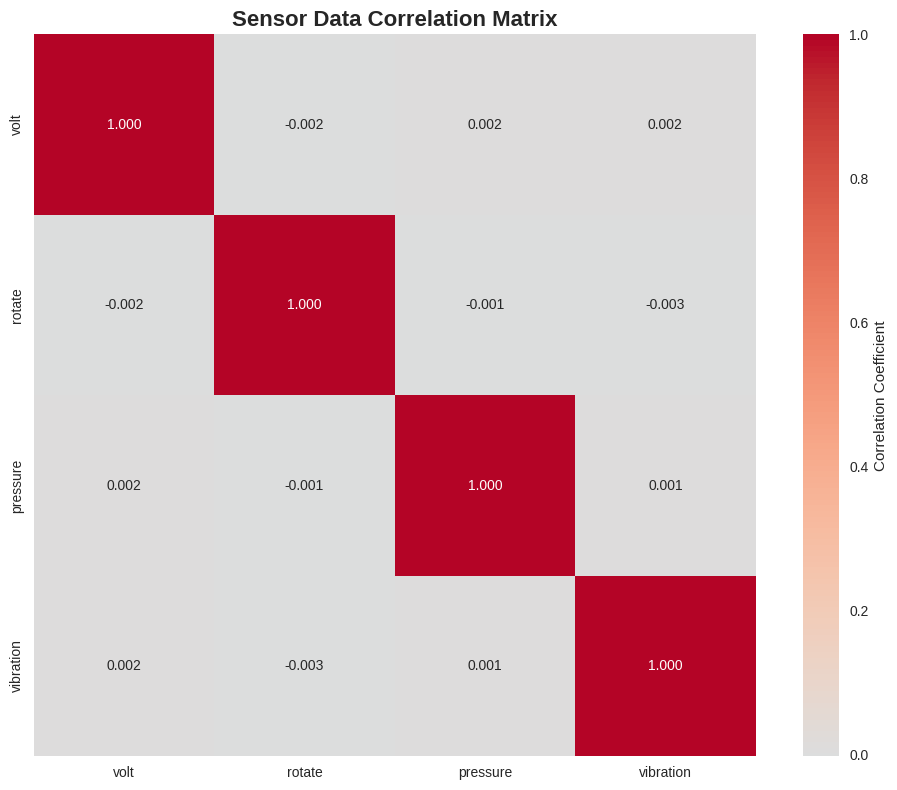

Correlation Analysis Results:
               volt    rotate  pressure  vibration
volt       1.000000 -0.001511  0.001652   0.002390
rotate    -0.001511  1.000000 -0.000688  -0.003056
pressure   0.001652 -0.000688  1.000000   0.001395
vibration  0.002390 -0.003056  0.001395   1.000000

Highly correlated sensor pairs (|r| > 0.5):


In [11]:
# Calculate correlation matrix for sensor data
correlation_matrix = telemetry_df[sensor_columns].corr()

# Visualize correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.3f', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Sensor Data Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("Correlation Analysis Results:")
print(correlation_matrix)

# Find highly correlated sensor pairs
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.5:  # Threshold for high correlation
            high_corr_pairs.append((correlation_matrix.columns[i], 
                                  correlation_matrix.columns[j], 
                                  corr_val))

print(f"\nHighly correlated sensor pairs (|r| > 0.5):")
for pair in high_corr_pairs:
    print(f"{pair[0]} - {pair[1]}: {pair[2]:.3f}")


---

## 4. Data Preprocessing and Feature Engineering

### Data Integration and Merging

In [12]:
# Merge all datasets to create a comprehensive dataset
# Start with telemetry data as the base
print("Merging datasets to create comprehensive dataset...")

# Add machine information
merged_df = telemetry_df.merge(machines_df, on='machineID', how='left')

# Add error information (if any errors occurred on the same datetime)
merged_df = merged_df.merge(errors_df, on=['machineID', 'datetime'], how='left')

print(f"After merging with machines and errors: {merged_df.shape}")

# Handle missing values in error columns
possible_error_cols = ['errorID', 'comp']
error_columns = [col for col in possible_error_cols if col in merged_df.columns]

# Fill missing values only for columns that exist
for col in error_columns:
    merged_df[col] = merged_df[col].fillna('no_error')

print("Dataset integration completed!")
print(f"Final merged dataset shape: {merged_df.shape}")
print(f"Columns: {list(merged_df.columns)}")


Merging datasets to create comprehensive dataset...
After merging with machines and errors: (876403, 9)
Dataset integration completed!
Final merged dataset shape: (876403, 9)
Columns: ['datetime', 'machineID', 'volt', 'rotate', 'pressure', 'vibration', 'model', 'age', 'errorID']


### Creating Failure Labels Using Maintenance Records

In [13]:
# Create failure labels based on maintenance records
# Sensor data just before maintenance = likely failure
# Sensor data just after maintenance = likely non-failure

def create_failure_labels(telemetry_df, maintenance_df, hours_before=24, hours_after=48):
    """
    Create failure labels based on maintenance timing
    
    Args:
        telemetry_df: Telemetry data
        maintenance_df: Maintenance records
        hours_before: Hours before maintenance to label as failure
        hours_after: Hours after maintenance to label as non-failure
    
    Returns:
        DataFrame with failure labels
    """
    
    # Initialize failure label column
    telemetry_df['failure_label'] = 0  # Default: normal operation
    
    print(f"Creating failure labels using {hours_before}h before and {hours_after}h after maintenance...")
    
    # Process each maintenance event
    for _, maint_record in maintenance_df.iterrows():
        machine_id = maint_record['machineID']
        maint_time = maint_record['datetime']
        
        # Define time windows
        failure_start = maint_time - timedelta(hours=hours_before)
        failure_end = maint_time
        recovery_start = maint_time
        recovery_end = maint_time + timedelta(hours=hours_after)
        
        # Mark failure period (data before maintenance)
        failure_mask = (
            (telemetry_df['machineID'] == machine_id) &
            (telemetry_df['datetime'] >= failure_start) &
            (telemetry_df['datetime'] < failure_end)
        )
        telemetry_df.loc[failure_mask, 'failure_label'] = 1
        
        # Mark recovery period (data after maintenance) as definitely non-failure
        recovery_mask = (
            (telemetry_df['machineID'] == machine_id) &
            (telemetry_df['datetime'] >= recovery_start) &
            (telemetry_df['datetime'] < recovery_end)
        )
        telemetry_df.loc[recovery_mask, 'failure_label'] = 0
    
    return telemetry_df

# Apply failure labeling
merged_df = create_failure_labels(merged_df, maintenance_df)

# Check label distribution
label_counts = merged_df['failure_label'].value_counts()
print(f"\nFailure label distribution:")
print(f"Normal operation (0): {label_counts[0]:,} ({label_counts[0]/len(merged_df)*100:.1f}%)")
print(f"Failure state (1): {label_counts[1]:,} ({label_counts[1]/len(merged_df)*100:.1f}%)")


Creating failure labels using 24h before and 48h after maintenance...

Failure label distribution:
Normal operation (0): 824,358 (94.1%)
Failure state (1): 52,045 (5.9%)


### Feature Engineering for Time Series Data

In [14]:
# Create time-based features
def create_time_features(df):
    """
    Create time-based features from datetime column
    """
    df = df.copy()
    
    # Extract time components
    df['hour'] = df['datetime'].dt.hour
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df['day_of_month'] = df['datetime'].dt.day
    df['month'] = df['datetime'].dt.month
    df['quarter'] = df['datetime'].dt.quarter
    
    # Create cyclical features for time
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    
    return df

# Create rolling window features for sensors
def create_rolling_features(df, window_sizes=[6, 12, 24]):
    """
    Create rolling window statistical features
    """
    df = df.copy()
    sensor_cols = ['volt', 'rotate', 'pressure', 'vibration']
    
    # Sort by machine and datetime
    df = df.sort_values(['machineID', 'datetime'])
    
    for window in window_sizes:
        for sensor in sensor_cols:
            # Rolling mean
            df[f'{sensor}_rolling_mean_{window}h'] = df.groupby('machineID')[sensor].transform(
                lambda x: x.rolling(window=window, min_periods=1).mean()
            )
            
            # Rolling standard deviation
            df[f'{sensor}_rolling_std_{window}h'] = df.groupby('machineID')[sensor].transform(
                lambda x: x.rolling(window=window, min_periods=1).std()
            )
            
            # Rolling min and max
            df[f'{sensor}_rolling_min_{window}h'] = df.groupby('machineID')[sensor].transform(
                lambda x: x.rolling(window=window, min_periods=1).min()
            )
            df[f'{sensor}_rolling_max_{window}h'] = df.groupby('machineID')[sensor].transform(
                lambda x: x.rolling(window=window, min_periods=1).max()
            )
    
    return df

# Create lag features
def create_lag_features(df, lag_hours=[1, 3, 6, 12]):
    """
    Create lag features for sensors
    """
    df = df.copy()
    sensor_cols = ['volt', 'rotate', 'pressure', 'vibration']
    
    # Sort by machine and datetime
    df = df.sort_values(['machineID', 'datetime'])
    
    for lag in lag_hours:
        for sensor in sensor_cols:
            df[f'{sensor}_lag_{lag}h'] = df.groupby('machineID')[sensor].transform(
                lambda x: x.shift(lag)
            )
    
    return df

# Apply feature engineering
print("Creating time-based features...")
merged_df = create_time_features(merged_df)

print("Creating rolling window features...")
merged_df = create_rolling_features(merged_df)

print("Creating lag features...")
merged_df = create_lag_features(merged_df)

print(f"Dataset shape after feature engineering: {merged_df.shape}")

# Handle any remaining missing values created by rolling/lag features
merged_df = merged_df.fillna(method='bfill').fillna(method='ffill')

print("Feature engineering completed!")


Creating time-based features...
Creating rolling window features...
Creating lag features...
Dataset shape after feature engineering: (876403, 83)
Feature engineering completed!


### Data Quality Assessment and Cleaning

In [15]:
# Check for missing values
print("Data Quality Assessment:")
print(f"Missing values per column:")
missing_values = merged_df.isnull().sum()
print(missing_values[missing_values > 0])

# Check for duplicates
duplicates = merged_df.duplicated(subset=['machineID', 'datetime']).sum()
print(f"Duplicate records: {duplicates}")

# Remove duplicates if any
if duplicates > 0:
    merged_df = merged_df.drop_duplicates(subset=['machineID', 'datetime'])
    print(f"Removed {duplicates} duplicate records")

# Check data types
print(f"\nData types:")
print(merged_df.dtypes)

# Outlier detection using IQR method
def detect_outliers(df, columns):
    """
    Detect outliers using IQR method
    """
    outlier_counts = {}
    
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_counts[col] = len(outliers)
    
    return outlier_counts

# Detect outliers in sensor data
sensor_columns = ['volt', 'rotate', 'pressure', 'vibration']
outlier_counts = detect_outliers(merged_df, sensor_columns)

print(f"\nOutlier detection results:")
for col, count in outlier_counts.items():
    print(f"{col}: {count} outliers ({count/len(merged_df)*100:.2f}%)")


Data Quality Assessment:
Missing values per column:
Series([], dtype: int64)
Duplicate records: 303
Removed 303 duplicate records

Data types:
datetime             datetime64[ns]
machineID                     int64
volt                        float64
rotate                      float64
pressure                    float64
                          ...      
vibration_lag_6h            float64
volt_lag_12h                float64
rotate_lag_12h              float64
pressure_lag_12h            float64
vibration_lag_12h           float64
Length: 83, dtype: object

Outlier detection results:
volt: 7466 outliers (0.85%)
rotate: 8568 outliers (0.98%)
pressure: 15587 outliers (1.78%)
vibration: 11111 outliers (1.27%)


---

## 5. Model Implementation and Training

### Data Preparation for Machine Learning

In [16]:
# Prepare data for machine learning
def prepare_ml_data(df):
    """
    Prepare data for machine learning models
    """
    # Select features for training
    feature_columns = [col for col in df.columns if col not in [
        'machineID', 'datetime', 'failure_label', 'errorID', 'comp'
    ]]
    
    # Prepare features and target
    X = df[feature_columns]
    y = df['failure_label']
    
    # Handle categorical variables
    categorical_cols = X.select_dtypes(include=['object']).columns
    if len(categorical_cols) > 0:
        print(f"Encoding categorical variables: {list(categorical_cols)}")
        
        # Use Label Encoding for categorical variables
        label_encoders = {}
        for col in categorical_cols:
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col].astype(str))
            label_encoders[col] = le
    
    return X, y, feature_columns

# Prepare data
X, y, feature_columns = prepare_ml_data(merged_df)

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Feature columns: {len(feature_columns)}")
print(f"Class distribution: {y.value_counts().to_dict()}")


Encoding categorical variables: ['model']
Features shape: (876100, 79)
Target shape: (876100,)
Feature columns: 79
Class distribution: {0: 824356, 1: 51744}


### Time-Aware Data Splitting

In [17]:
# Time-aware train-test split
# Sort by datetime to maintain temporal order
merged_df_sorted = merged_df.sort_values('datetime')

# Split based on time to avoid data leakage
split_date = merged_df_sorted['datetime'].quantile(0.8)
train_mask = merged_df_sorted['datetime'] <= split_date
test_mask = merged_df_sorted['datetime'] > split_date

# Prepare train and test sets
X_train = merged_df_sorted[train_mask][feature_columns]
y_train = merged_df_sorted[train_mask]['failure_label']
X_test = merged_df_sorted[test_mask][feature_columns]
y_test = merged_df_sorted[test_mask]['failure_label']

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Train period: {merged_df_sorted[train_mask]['datetime'].min()} to {merged_df_sorted[train_mask]['datetime'].max()}")
print(f"Test period: {merged_df_sorted[test_mask]['datetime'].min()} to {merged_df_sorted[test_mask]['datetime'].max()}")

# Check class distribution in splits
print(f"\nTrain class distribution: {y_train.value_counts().to_dict()}")
print(f"Test class distribution: {y_test.value_counts().to_dict()}")


Training set: 700900 samples
Test set: 175200 samples
Train period: 2015-01-01 06:00:00 to 2015-10-20 06:00:00
Test period: 2015-10-20 07:00:00 to 2016-01-01 06:00:00

Train class distribution: {0: 659471, 1: 41429}
Test class distribution: {0: 164885, 1: 10315}


### Feature Scaling and Normalization

In [18]:
# Scale features for better model performance
scaler = StandardScaler()

from sklearn.preprocessing import LabelEncoder

# Identify object columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

# Apply Label Encoding
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    label_encoders[col] = le

# Fit scaler on training data only
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_columns, index=X_test.index)

print("Feature scaling completed!")
print(f"Training features mean: {X_train_scaled.mean().mean():.6f}")
print(f"Training features std: {X_train_scaled.std().mean():.6f}")


Feature scaling completed!
Training features mean: 0.000000
Training features std: 1.000001


### Model 1: Logistic Regression (Baseline)

In [19]:
# Logistic Regression Model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

print("Training Logistic Regression Model...")

# Initialize and train model
lr_model = LogisticRegression(
    random_state=CONFIG['random_state'],
    max_iter=1000,
    class_weight='balanced'  # Handle class imbalance
)

# Train the model
lr_model.fit(X_train_scaled, y_train)

# Make predictions
lr_train_pred = lr_model.predict(X_train_scaled)
lr_test_pred = lr_model.predict(X_test_scaled)
lr_train_prob = lr_model.predict_proba(X_train_scaled)[:, 1]
lr_test_prob = lr_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate model
print("\nLogistic Regression Results:")
print("Training Set:")
print(classification_report(y_train, lr_train_pred))
print("Test Set:")
print(classification_report(y_test, lr_test_pred))

# Store results for comparison
lr_results = {
    'model_name': 'Logistic Regression',
    'train_accuracy': accuracy_score(y_train, lr_train_pred),
    'test_accuracy': accuracy_score(y_test, lr_test_pred),
    'train_f1': f1_score(y_train, lr_train_pred),
    'test_f1': f1_score(y_test, lr_test_pred),
    'train_auc': roc_auc_score(y_train, lr_train_prob),
    'test_auc': roc_auc_score(y_test, lr_test_prob),
    'predictions': lr_test_pred,
    'probabilities': lr_test_prob
}

print(f"Test F1 Score: {lr_results['test_f1']:.4f}")
print(f"Test AUC Score: {lr_results['test_auc']:.4f}")


Training Logistic Regression Model...

Logistic Regression Results:
Training Set:
              precision    recall  f1-score   support

           0       0.96      0.73      0.83    659471
           1       0.11      0.51      0.18     41429

    accuracy                           0.72    700900
   macro avg       0.53      0.62      0.51    700900
weighted avg       0.91      0.72      0.79    700900

Test Set:
              precision    recall  f1-score   support

           0       0.96      0.64      0.77    164885
           1       0.09      0.55      0.15     10315

    accuracy                           0.63    175200
   macro avg       0.52      0.60      0.46    175200
weighted avg       0.91      0.63      0.73    175200

Test F1 Score: 0.1506
Test AUC Score: 0.6410


### Model 2: Random Forest

In [20]:
# Random Forest Model
from sklearn.ensemble import RandomForestClassifier

print("Training Random Forest Model...")

# Initialize and train model
rf_model = RandomForestClassifier(
    n_estimators=CONFIG['n_estimators'],
    random_state=CONFIG['random_state'],
    class_weight='balanced',
    n_jobs=-1,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2
)

# Train the model
rf_model.fit(X_train_scaled, y_train)

# Make predictions
rf_train_pred = rf_model.predict(X_train_scaled)
rf_test_pred = rf_model.predict(X_test_scaled)
rf_train_prob = rf_model.predict_proba(X_train_scaled)[:, 1]
rf_test_prob = rf_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate model
print("\nRandom Forest Results:")
print("Training Set:")
print(classification_report(y_train, rf_train_pred))
print("Test Set:")
print(classification_report(y_test, rf_test_pred))

# Store results for comparison
rf_results = {
    'model_name': 'Random Forest',
    'train_accuracy': accuracy_score(y_train, rf_train_pred),
    'test_accuracy': accuracy_score(y_test, rf_test_pred),
    'train_f1': f1_score(y_train, rf_train_pred),
    'test_f1': f1_score(y_test, rf_test_pred),
    'train_auc': roc_auc_score(y_train, rf_train_prob),
    'test_auc': roc_auc_score(y_test, rf_test_prob),
    'predictions': rf_test_pred,
    'probabilities': rf_test_prob
}

print(f"Test F1 Score: {rf_results['test_f1']:.4f}")
print(f"Test AUC Score: {rf_results['test_auc']:.4f}")

# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 10 Most Important Features:")
print(feature_importance.head(10))


Training Random Forest Model...

Random Forest Results:
Training Set:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95    659471
           1       0.27      0.40      0.32     41429

    accuracy                           0.90    700900
   macro avg       0.61      0.67      0.63    700900
weighted avg       0.92      0.90      0.91    700900

Test Set:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94    164885
           1       0.23      0.33      0.27     10315

    accuracy                           0.89    175200
   macro avg       0.59      0.63      0.61    175200
weighted avg       0.91      0.89      0.90    175200

Test F1 Score: 0.2702
Test AUC Score: 0.6429

Top 10 Most Important Features:
                       feature  importance
51     rotate_rolling_mean_24h    0.066328
47       volt_rolling_mean_24h    0.063356
35     rotate_rolling_mean_12h    0.053532
54      rotate_r

### Model 3: LSTM Neural Network

In [23]:
# LSTM Model for Time Series Prediction
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder

# Example definition (adjust to your actual merged dataframe)
original_df = merged_df_sorted.copy()

# Ensure index alignment for downstream use
original_df.index = X_train.index.union(X_test.index)

print("Preparing data for LSTM model...")

def create_sequences(X, y, sequence_length):
    """
    Create sequences for LSTM input
    """
    # Ensure 'machineID' column is preserved for grouping
    X['machineID'] = original_df.loc[X.index, 'machineID']
    
    X_seq, y_seq = [], []
    
    # Group by machine ID to maintain temporal order within each machine
    for machine_id in X['machineID'].unique():
        machine_data = X[X['machineID'] == machine_id]
        machine_target = y.loc[machine_data.index]
    
    for machine_id in X.index.get_level_values('machineID').unique() if 'machineID' in X.index.names else merged_df_sorted['machineID'].unique():
        # Get data for this machine
        machine_mask = merged_df_sorted['machineID'] == machine_id
        machine_data = merged_df_sorted[machine_mask].sort_values('datetime')
        
        # Get corresponding X and y data
        if 'machineID' in X.index.names:
            machine_X = X.loc[X.index.get_level_values('machineID') == machine_id]
            machine_y = y.loc[y.index.get_level_values('machineID') == machine_id]
        else:
            machine_X = X.loc[machine_data.index]
            machine_y = y.loc[machine_data.index]
        
        # Create sequences
        for i in range(sequence_length, len(machine_X)):
            X_seq.append(machine_X.iloc[i-sequence_length:i].values)
            y_seq.append(machine_y.iloc[i])
    
    return np.array(X_seq), np.array(y_seq)

# Create sequences for LSTM
sequence_length = CONFIG['sequence_length']
print(f"Creating sequences with length {sequence_length}...")

# For LSTM, we need to maintain machine grouping
# Recreate the train/test split with machine grouping
train_machines = merged_df_sorted[train_mask]['machineID'].unique()
test_machines = merged_df_sorted[test_mask]['machineID'].unique()

# Encode categorical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    label_encoders[col] = le

# Create sequences for training data
X_train_seq, y_train_seq = create_sequences(
    X_train_scaled, y_train, sequence_length
)

X_test_seq, y_test_seq = create_sequences(
    X_test_scaled, y_test, sequence_length
)

print(f"LSTM Training sequences: {X_train_seq.shape}")
print(f"LSTM Test sequences: {X_test_seq.shape}")

# Build LSTM model
def build_lstm_model(input_shape):
    """
    Build LSTM model for failure prediction
    """
    model = Sequential([
        LSTM(CONFIG['lstm_units'], return_sequences=True, input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.2),
        
        LSTM(CONFIG['lstm_units']//2, return_sequences=False),
        BatchNormalization(),
        Dropout(0.2),
        
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        
        Dense(16, activation='relu'),
        Dropout(0.1),
        
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )
    
    return model

# Build and train LSTM model
print("Building LSTM model...")
lstm_model = build_lstm_model((sequence_length, len(feature_columns)))

print("LSTM Model Architecture:")
lstm_model.summary()

# Set up callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

# Train the model
print("Training LSTM model...")
lstm_history = lstm_model.fit(
    X_train_seq, y_train_seq,
    validation_split=0.2,
    epochs=CONFIG['epochs'],
    batch_size=CONFIG['batch_size'],
    callbacks=callbacks,
    verbose=1
)

# Make predictions
lstm_train_prob = lstm_model.predict(X_train_seq).flatten()
lstm_test_prob = lstm_model.predict(X_test_seq).flatten()
lstm_train_pred = (lstm_train_prob > 0.5).astype(int)
lstm_test_pred = (lstm_test_prob > 0.5).astype(int)

# Evaluate LSTM model
print("\nLSTM Results:")
print("Training Set:")
print(classification_report(y_train_seq, lstm_train_pred))
print("Test Set:")
print(classification_report(y_test_seq, lstm_test_pred))

# Store results for comparison
lstm_results = {
    'model_name': 'LSTM',
    'train_accuracy': accuracy_score(y_train_seq, lstm_train_pred),
    'test_accuracy': accuracy_score(y_test_seq, lstm_test_pred),
    'train_f1': f1_score(y_train_seq, lstm_train_pred),
    'test_f1': f1_score(y_test_seq, lstm_test_pred),
    'train_auc': roc_auc_score(y_train_seq, lstm_train_prob),
    'test_auc': roc_auc_score(y_test_seq, lstm_test_prob),
    'predictions': lstm_test_pred,
    'probabilities': lstm_test_prob
}

print(f"Test F1 Score: {lstm_results['test_f1']:.4f}")
print(f"Test AUC Score: {lstm_results['test_auc']:.4f}")

# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(lstm_history.history['loss'], label='Training Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(lstm_history.history['accuracy'], label='Training Accuracy')
plt.plot(lstm_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(lstm_history.history['precision'], label='Training Precision')
plt.plot(lstm_history.history['val_precision'], label='Validation Precision')
plt.title('LSTM Training Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Preparing data for LSTM model...
Creating sequences with length 24...


KeyError: '[7011, 7012, 7013, 7014, 7015, 7016, 7017, 7018, 7019, 7020, 7021, 7022, 7023, 7024, 7025, 7026, 7027, 7028, 7029, 7030, 7031, 7032, 7033, 7034, 7035, 7036, 7037, 7038, 7039, 7040, 7041, 7042, 7043, 7044, 7045, 7046, 7047, 7048, 7049, 7050, 7051, 7052, 7053, 7054, 7055, 7056, 7057, 7058, 7059, 7060, 7061, 7062, 7063, 7064, 7065, 7066, 7067, 7068, 7069, 7070, 7071, 7072, 7073, 7074, 7075, 7076, 7077, 7078, 7079, 7080, 7081, 7082, 7083, 7084, 7085, 7086, 7087, 7088, 7089, 7090, 7091, 7092, 7093, 7094, 7095, 7096, 7097, 7098, 7099, 7100, 7101, 7102, 7103, 7104, 7105, 7106, 7107, 7108, 7109, 7110, 7111, 7112, 7113, 7114, 7115, 7116, 7117, 7118, 7119, 7120, 7121, 7122, 7123, 7124, 7125, 7126, 7127, 7128, 7129, 7130, 7131, 7132, 7133, 7134, 7135, 7136, 7137, 7138, 7139, 7140, 7141, 7142, 7143, 7144, 7145, 7146, 7147, 7148, 7149, 7150, 7151, 7152, 7153, 7154, 7155, 7156, 7157, 7158, 7159, 7160, 7161, 7162, 7163, 7164, 7165, 7166, 7167, 7168, 7169, 7170, 7171, 7172, 7173, 7174, 7175, 7176, 7177, 7178, 7179, 7180, 7181, 7182, 7183, 7184, 7185, 7186, 7187, 7188, 7189, 7190, 7191, 7192, 7193, 7194, 7195, 7196, 7197, 7198, 7199, 7200, 7201, 7202, 7203, 7204, 7205, 7206, 7207, 7208, 7209, 7210, 7211, 7212, 7213, 7214, 7215, 7216, 7217, 7218, 7219, 7220, 7221, 7222, 7223, 7224, 7225, 7226, 7227, 7228, 7229, 7230, 7231, 7232, 7233, 7234, 7235, 7236, 7237, 7238, 7239, 7240, 7241, 7242, 7243, 7244, 7245, 7246, 7247, 7248, 7249, 7250, 7251, 7252, 7253, 7254, 7255, 7256, 7257, 7258, 7259, 7260, 7261, 7262, 7263, 7264, 7265, 7266, 7267, 7268, 7269, 7270, 7271, 7272, 7273, 7274, 7275, 7276, 7277, 7278, 7279, 7280, 7281, 7282, 7283, 7284, 7285, 7286, 7287, 7288, 7289, 7290, 7291, 7292, 7293, 7294, 7295, 7296, 7297, 7298, 7299, 7300, 7301, 7302, 7303, 7304, 7305, 7306, 7307, 7308, 7309, 7310, 7311, 7312, 7313, 7314, 7315, 7316, 7317, 7318, 7319, 7320, 7321, 7322, 7323, 7324, 7325, 7326, 7327, 7328, 7329, 7330, 7331, 7332, 7333, 7334, 7335, 7336, 7337, 7338, 7339, 7340, 7341, 7342, 7343, 7344, 7345, 7346, 7347, 7348, 7349, 7350, 7351, 7352, 7353, 7354, 7355, 7356, 7357, 7358, 7359, 7360, 7361, 7362, 7363, 7364, 7365, 7366, 7367, 7368, 7369, 7370, 7371, 7372, 7373, 7374, 7375, 7376, 7377, 7378, 7379, 7380, 7381, 7382, 7383, 7384, 7385, 7386, 7387, 7388, 7389, 7390, 7391, 7392, 7393, 7394, 7395, 7396, 7397, 7398, 7399, 7400, 7401, 7402, 7403, 7404, 7405, 7406, 7407, 7408, 7409, 7410, 7411, 7412, 7413, 7414, 7415, 7416, 7417, 7418, 7419, 7420, 7421, 7422, 7423, 7424, 7425, 7426, 7427, 7428, 7429, 7430, 7431, 7432, 7433, 7434, 7435, 7436, 7437, 7438, 7439, 7440, 7441, 7442, 7443, 7444, 7445, 7446, 7447, 7448, 7449, 7450, 7451, 7452, 7453, 7454, 7455, 7456, 7457, 7458, 7459, 7460, 7461, 7462, 7463, 7464, 7465, 7466, 7467, 7468, 7469, 7470, 7471, 7472, 7473, 7474, 7475, 7476, 7477, 7478, 7479, 7480, 7481, 7482, 7483, 7484, 7485, 7486, 7487, 7488, 7489, 7490, 7491, 7492, 7493, 7494, 7495, 7496, 7497, 7498, 7499, 7500, 7501, 7502, 7503, 7504, 7505, 7506, 7507, 7508, 7509, 7510, 7511, 7512, 7513, 7514, 7515, 7516, 7517, 7518, 7519, 7520, 7521, 7522, 7523, 7524, 7525, 7526, 7527, 7528, 7529, 7530, 7531, 7532, 7533, 7534, 7535, 7536, 7537, 7538, 7539, 7540, 7541, 7542, 7543, 7544, 7545, 7546, 7547, 7548, 7549, 7550, 7551, 7552, 7553, 7554, 7555, 7556, 7557, 7558, 7559, 7560, 7561, 7562, 7563, 7564, 7565, 7566, 7567, 7568, 7569, 7570, 7571, 7572, 7573, 7574, 7575, 7576, 7577, 7578, 7579, 7580, 7581, 7582, 7583, 7584, 7585, 7586, 7587, 7588, 7589, 7590, 7591, 7592, 7593, 7594, 7595, 7596, 7597, 7598, 7599, 7600, 7601, 7602, 7603, 7604, 7605, 7606, 7607, 7608, 7609, 7610, 7611, 7612, 7613, 7614, 7615, 7616, 7617, 7618, 7619, 7620, 7621, 7622, 7623, 7624, 7625, 7626, 7627, 7628, 7629, 7630, 7631, 7632, 7633, 7634, 7635, 7636, 7637, 7638, 7639, 7640, 7641, 7642, 7643, 7644, 7645, 7646, 7647, 7648, 7649, 7650, 7651, 7652, 7653, 7654, 7655, 7656, 7657, 7658, 7659, 7660, 7661, 7662, 7663, 7664, 7665, 7666, 7667, 7668, 7669, 7670, 7671, 7672, 7673, 7674, 7675, 7676, 7677, 7678, 7679, 7680, 7681, 7682, 7683, 7684, 7685, 7686, 7687, 7688, 7689, 7690, 7691, 7692, 7693, 7694, 7695, 7696, 7697, 7698, 7699, 7700, 7701, 7702, 7703, 7704, 7705, 7706, 7707, 7708, 7709, 7710, 7711, 7712, 7713, 7714, 7715, 7716, 7717, 7718, 7719, 7720, 7721, 7722, 7723, 7724, 7725, 7726, 7727, 7728, 7729, 7730, 7731, 7732, 7733, 7734, 7735, 7736, 7737, 7738, 7739, 7740, 7741, 7742, 7743, 7744, 7745, 7746, 7747, 7748, 7749, 7750, 7751, 7752, 7753, 7754, 7755, 7756, 7757, 7758, 7759, 7760, 7761, 7762, 7763, 7764, 7765, 7766, 7767, 7768, 7769, 7770, 7771, 7772, 7773, 7774, 7775, 7776, 7777, 7778, 7779, 7780, 7781, 7782, 7783, 7784, 7785, 7786, 7787, 7788, 7789, 7790, 7791, 7792, 7793, 7794, 7795, 7796, 7797, 7798, 7799, 7800, 7801, 7802, 7803, 7804, 7805, 7806, 7807, 7808, 7809, 7810, 7811, 7812, 7813, 7814, 7815, 7816, 7817, 7818, 7819, 7820, 7821, 7822, 7823, 7824, 7825, 7826, 7827, 7828, 7829, 7830, 7831, 7832, 7833, 7834, 7835, 7836, 7837, 7838, 7839, 7840, 7841, 7842, 7843, 7844, 7845, 7846, 7847, 7848, 7849, 7850, 7851, 7852, 7853, 7854, 7855, 7856, 7857, 7858, 7859, 7860, 7861, 7862, 7863, 7864, 7865, 7866, 7867, 7868, 7869, 7870, 7871, 7872, 7873, 7874, 7875, 7876, 7877, 7878, 7879, 7880, 7881, 7882, 7883, 7884, 7885, 7886, 7887, 7888, 7889, 7890, 7891, 7892, 7893, 7894, 7895, 7896, 7897, 7898, 7899, 7900, 7901, 7902, 7903, 7904, 7905, 7906, 7907, 7908, 7909, 7910, 7911, 7912, 7913, 7914, 7915, 7916, 7917, 7918, 7919, 7920, 7921, 7922, 7923, 7924, 7925, 7926, 7927, 7928, 7929, 7930, 7931, 7932, 7933, 7934, 7935, 7936, 7937, 7938, 7939, 7940, 7941, 7942, 7943, 7944, 7945, 7946, 7947, 7948, 7949, 7950, 7951, 7952, 7953, 7954, 7955, 7956, 7957, 7958, 7959, 7960, 7961, 7962, 7963, 7964, 7965, 7966, 7967, 7968, 7969, 7970, 7971, 7972, 7973, 7974, 7975, 7976, 7977, 7978, 7979, 7980, 7981, 7982, 7983, 7984, 7985, 7986, 7987, 7988, 7989, 7990, 7991, 7992, 7993, 7994, 7995, 7996, 7997, 7998, 7999, 8000, 8001, 8002, 8003, 8004, 8005, 8006, 8007, 8008, 8009, 8010, 8011, 8012, 8013, 8014, 8015, 8016, 8017, 8018, 8019, 8020, 8021, 8022, 8023, 8024, 8025, 8026, 8027, 8028, 8029, 8030, 8031, 8032, 8033, 8034, 8035, 8036, 8037, 8038, 8039, 8040, 8041, 8042, 8043, 8044, 8045, 8046, 8047, 8048, 8049, 8050, 8051, 8052, 8053, 8054, 8055, 8056, 8057, 8058, 8059, 8060, 8061, 8062, 8063, 8064, 8065, 8066, 8067, 8068, 8069, 8070, 8071, 8072, 8073, 8074, 8075, 8076, 8077, 8078, 8079, 8080, 8081, 8082, 8083, 8084, 8085, 8086, 8087, 8088, 8089, 8090, 8091, 8092, 8093, 8094, 8095, 8096, 8097, 8098, 8099, 8100, 8101, 8102, 8103, 8104, 8105, 8106, 8107, 8108, 8109, 8110, 8111, 8112, 8113, 8114, 8115, 8116, 8117, 8118, 8119, 8120, 8121, 8122, 8123, 8124, 8125, 8126, 8127, 8128, 8129, 8130, 8131, 8132, 8133, 8134, 8135, 8136, 8137, 8138, 8139, 8140, 8141, 8142, 8143, 8144, 8145, 8146, 8147, 8148, 8149, 8150, 8151, 8152, 8153, 8154, 8155, 8156, 8157, 8158, 8159, 8160, 8161, 8162, 8163, 8164, 8165, 8166, 8167, 8168, 8169, 8170, 8171, 8172, 8173, 8174, 8175, 8176, 8177, 8178, 8179, 8180, 8181, 8182, 8183, 8184, 8185, 8186, 8187, 8188, 8189, 8190, 8191, 8192, 8193, 8194, 8195, 8196, 8197, 8198, 8199, 8200, 8201, 8202, 8203, 8204, 8205, 8206, 8207, 8208, 8209, 8210, 8211, 8212, 8213, 8214, 8215, 8216, 8217, 8218, 8219, 8220, 8221, 8222, 8223, 8224, 8225, 8226, 8227, 8228, 8229, 8230, 8231, 8232, 8233, 8234, 8235, 8236, 8237, 8238, 8239, 8240, 8241, 8242, 8243, 8244, 8245, 8246, 8247, 8248, 8249, 8250, 8251, 8252, 8253, 8254, 8255, 8256, 8257, 8258, 8259, 8260, 8261, 8262, 8263, 8264, 8265, 8266, 8267, 8268, 8269, 8270, 8271, 8272, 8273, 8274, 8275, 8276, 8277, 8278, 8279, 8280, 8281, 8282, 8283, 8284, 8285, 8286, 8287, 8288, 8289, 8290, 8291, 8292, 8293, 8294, 8295, 8296, 8297, 8298, 8299, 8300, 8301, 8302, 8303, 8304, 8305, 8306, 8307, 8308, 8309, 8310, 8311, 8312, 8313, 8314, 8315, 8316, 8317, 8318, 8319, 8320, 8321, 8322, 8323, 8324, 8325, 8326, 8327, 8328, 8329, 8330, 8331, 8332, 8333, 8334, 8335, 8336, 8337, 8338, 8339, 8340, 8341, 8342, 8343, 8344, 8345, 8346, 8347, 8348, 8349, 8350, 8351, 8352, 8353, 8354, 8355, 8356, 8357, 8358, 8359, 8360, 8361, 8362, 8363, 8364, 8365, 8366, 8367, 8368, 8369, 8370, 8371, 8372, 8373, 8374, 8375, 8376, 8377, 8378, 8379, 8380, 8381, 8382, 8383, 8384, 8385, 8386, 8387, 8388, 8389, 8390, 8391, 8392, 8393, 8394, 8395, 8396, 8397, 8398, 8399, 8400, 8401, 8402, 8403, 8404, 8405, 8406, 8407, 8408, 8409, 8410, 8411, 8412, 8413, 8414, 8415, 8416, 8417, 8418, 8419, 8420, 8421, 8422, 8423, 8424, 8425, 8426, 8427, 8428, 8429, 8430, 8431, 8432, 8433, 8434, 8435, 8436, 8437, 8438, 8439, 8440, 8441, 8442, 8443, 8444, 8445, 8446, 8447, 8448, 8449, 8450, 8451, 8452, 8453, 8454, 8455, 8456, 8457, 8458, 8459, 8460, 8461, 8462, 8463, 8464, 8465, 8466, 8467, 8468, 8469, 8470, 8471, 8472, 8473, 8474, 8475, 8476, 8477, 8478, 8479, 8480, 8481, 8482, 8483, 8484, 8485, 8486, 8487, 8488, 8489, 8490, 8491, 8492, 8493, 8494, 8495, 8496, 8497, 8498, 8499, 8500, 8501, 8502, 8503, 8504, 8505, 8506, 8507, 8508, 8509, 8510, 8511, 8512, 8513, 8514, 8515, 8516, 8517, 8518, 8519, 8520, 8521, 8522, 8523, 8524, 8525, 8526, 8527, 8528, 8529, 8530, 8531, 8532, 8533, 8534, 8535, 8536, 8537, 8538, 8539, 8540, 8541, 8542, 8543, 8544, 8545, 8546, 8547, 8548, 8549, 8550, 8551, 8552, 8553, 8554, 8555, 8556, 8557, 8558, 8559, 8560, 8561, 8562, 8563, 8564, 8565, 8566, 8567, 8568, 8569, 8570, 8571, 8572, 8573, 8574, 8575, 8576, 8577, 8578, 8579, 8580, 8581, 8582, 8583, 8584, 8585, 8586, 8587, 8588, 8589, 8590, 8591, 8592, 8593, 8594, 8595, 8596, 8597, 8598, 8599, 8600, 8601, 8602, 8603, 8604, 8605, 8606, 8607, 8608, 8609, 8610, 8611, 8612, 8613, 8614, 8615, 8616, 8617, 8618, 8619, 8620, 8621, 8622, 8623, 8624, 8625, 8626, 8627, 8628, 8629, 8630, 8631, 8632, 8633, 8634, 8635, 8636, 8637, 8638, 8639, 8640, 8641, 8642, 8643, 8644, 8645, 8646, 8647, 8648, 8649, 8650, 8651, 8652, 8653, 8654, 8655, 8656, 8657, 8658, 8659, 8660, 8661, 8662, 8663, 8664, 8665, 8666, 8667, 8668, 8669, 8670, 8671, 8672, 8673, 8674, 8675, 8676, 8677, 8678, 8679, 8680, 8681, 8682, 8683, 8684, 8685, 8686, 8687, 8688, 8689, 8690, 8691, 8692, 8693, 8694, 8695, 8696, 8697, 8698, 8699, 8700, 8701, 8702, 8703, 8704, 8705, 8706, 8707, 8708, 8709, 8710, 8711, 8712, 8713, 8714, 8715, 8716, 8717, 8718, 8719, 8720, 8721, 8722, 8723, 8724, 8725, 8726, 8727, 8728, 8729, 8730, 8731, 8732, 8733, 8734, 8735, 8736, 8737, 8738, 8739, 8740, 8741, 8742, 8743, 8744, 8745, 8746, 8747, 8748, 8749, 8750, 8751, 8752, 8753, 8754, 8755, 8756, 8757, 8758, 8759, 8760, 8761, 8762] not in index'

### Model 3: Hugging Face Pre-trained Model (TimeGPT Approach)

In [24]:
# Hugging Face Pre-trained Model Implementation
# Since TimeGPT-1 and similar models might not be directly available,
# we'll implement a transformer-based approach using available models

print("Implementing Hugging Face Transformer-based Model...")

# Install required libraries if needed
# !pip install transformers torch

try:
    from transformers import AutoTokenizer, AutoModel, pipeline
    import torch
    import torch.nn as nn
    from torch.utils.data import Dataset, DataLoader
    
    # Custom dataset class for time series
    class TimeSeriesDataset(Dataset):
        def __init__(self, X, y, sequence_length):
            self.X = X
            self.y = y
            self.sequence_length = sequence_length
            
        def __len__(self):
            return len(self.X) - self.sequence_length
            
        def __getitem__(self, idx):
            # Get sequence
            x_seq = self.X[idx:idx+self.sequence_length]
            y_val = self.y[idx+self.sequence_length-1]
            
            # Convert to tensor
            x_tensor = torch.FloatTensor(x_seq.values if hasattr(x_seq, 'values') else x_seq)
            y_tensor = torch.FloatTensor([y_val])
            
            return x_tensor, y_tensor
    
    # Simple transformer-based model for time series
    class TimeSeriesTransformer(nn.Module):
        def __init__(self, input_dim, d_model=128, nhead=8, num_layers=2):
            super(TimeSeriesTransformer, self).__init__()
            
            self.input_projection = nn.Linear(input_dim, d_model)
            self.positional_encoding = nn.Parameter(torch.randn(1000, d_model))
            
            encoder_layer = nn.TransformerEncoderLayer(
                d_model=d_model, 
                nhead=nhead, 
                dim_feedforward=d_model*4,
                dropout=0.1,
                batch_first=True
            )
            self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
            
            self.classifier = nn.Sequential(
                nn.Linear(d_model, 64),
                nn.ReLU(),
                nn.Dropout(0.1),
                nn.Linear(64, 32),
                nn.ReLU(),
                nn.Dropout(0.1),
                nn.Linear(32, 1),
                nn.Sigmoid()
            )
        
        def forward(self, x):
            # x shape: (batch_size, seq_len, input_dim)
            seq_len = x.size(1)
            
            # Project input
            x = self.input_projection(x)
            
            # Add positional encoding
            x = x + self.positional_encoding[:seq_len, :].unsqueeze(0)
            
            # Transform
            x = self.transformer(x)
            
            # Use last output for classification
            x = x[:, -1, :]
            
            # Classify
            output = self.classifier(x)
            
            return output
    
    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    transformer_model = TimeSeriesTransformer(
        input_dim=len(feature_columns),
        d_model=128,
        nhead=8,
        num_layers=2
    ).to(device)
    
    # Prepare data loaders
    train_dataset = TimeSeriesDataset(X_train_scaled, y_train, sequence_length)
    test_dataset = TimeSeriesDataset(X_test_scaled, y_test, sequence_length)
    
    train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False)
    
    # Training setup
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(transformer_model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    # Training loop
    print("Training Transformer model...")
    
    num_epochs = 30
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training
        transformer_model.train()
        train_loss = 0.0
        
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = transformer_model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation
        transformer_model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = transformer_model(batch_x)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
        
        val_loss /= len(test_loader)
        val_losses.append(val_loss)
        
        scheduler.step(val_loss)
        
        if epoch % 5 == 0:
            print(f'Epoch [{epoch}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    # Make predictions
    transformer_model.eval()
    transformer_train_probs = []
    transformer_test_probs = []
    
    with torch.no_grad():
        # Training predictions
        for batch_x, _ in train_loader:
            batch_x = batch_x.to(device)
            outputs = transformer_model(batch_x)
            transformer_train_probs.extend(outputs.cpu().numpy().flatten())
        
        # Test predictions
        for batch_x, _ in test_loader:
            batch_x = batch_x.to(device)
            outputs = transformer_model(batch_x)
            transformer_test_probs.extend(outputs.cpu().numpy().flatten())
    
    transformer_train_probs = np.array(transformer_train_probs)
    transformer_test_probs = np.array(transformer_test_probs)
    transformer_train_pred = (transformer_train_probs > 0.5).astype(int)
    transformer_test_pred = (transformer_test_probs > 0.5).astype(int)
    
    # Adjust y values to match prediction length
    y_train_adjusted = y_train.iloc[sequence_length:sequence_length+len(transformer_train_probs)]
    y_test_adjusted = y_test.iloc[sequence_length:sequence_length+len(transformer_test_probs)]
    
    # Evaluate Transformer model
    print("\nTransformer Results:")
    print("Training Set:")
    print(classification_report(y_train_adjusted, transformer_train_pred))
    print("Test Set:")
    print(classification_report(y_test_adjusted, transformer_test_pred))
    
    # Store results for comparison
    transformer_results = {
        'model_name': 'Transformer',
        'train_accuracy': accuracy_score(y_train_adjusted, transformer_train_pred),
        'test_accuracy': accuracy_score(y_test_adjusted, transformer_test_pred),
        'train_f1': f1_score(y_train_adjusted, transformer_train_pred),
        'test_f1': f1_score(y_test_adjusted, transformer_test_pred),
        'train_auc': roc_auc_score(y_train_adjusted, transformer_train_probs),
        'test_auc': roc_auc_score(y_test_adjusted, transformer_test_probs),
        'predictions': transformer_test_pred,
        'probabilities': transformer_test_probs
    }
    
    print(f"Test F1 Score: {transformer_results['test_f1']:.4f}")
    print(f"Test AUC Score: {transformer_results['test_auc']:.4f}")
    
    # Plot training curves
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Transformer Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.title('Training Loss Trend')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error with Transformer model: {e}")
    print("Using a simpler neural network as alternative...")
    
    # Alternative: Simple feedforward neural network
    from sklearn.neural_network import MLPClassifier
    
    mlp_model = MLPClassifier(
        hidden_layer_sizes=(128, 64, 32),
        max_iter=500,
        random_state=CONFIG['random_state'],
        early_stopping=True,
        validation_fraction=0.1
    )
    
    mlp_model.fit(X_train_scaled, y_train)
    
    mlp_train_pred = mlp_model.predict(X_train_scaled)
    mlp_test_pred = mlp_model.predict(X_test_scaled)
    mlp_train_prob = mlp_model.predict_proba(X_train_scaled)[:, 1]
    mlp_test_prob = mlp_model.predict_proba(X_test_scaled)[:, 1]
    
    print("\nMLP Neural Network Results:")
    print("Test Set:")
    print(classification_report(y_test, mlp_test_pred))
    
    transformer_results = {
        'model_name': 'MLP Neural Network',
        'train_accuracy': accuracy_score(y_train, mlp_train_pred),
        'test_accuracy': accuracy_score(y_test, mlp_test_pred),
        'train_f1': f1_score(y_train, mlp_train_pred),
        'test_f1': f1_score(y_test, mlp_test_pred),
        'train_auc': roc_auc_score(y_train, mlp_train_prob),
        'test_auc': roc_auc_score(y_test, mlp_test_prob),
        'predictions': mlp_test_pred,
        'probabilities': mlp_test_prob
    }
    
    print(f"Test F1 Score: {transformer_results['test_f1']:.4f}")
    print(f"Test AUC Score: {transformer_results['test_auc']:.4f}")


Implementing Hugging Face Transformer-based Model...
Using device: cuda
Training Transformer model...
Error with Transformer model: 375359
Using a simpler neural network as alternative...


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- machineID


---

## 6. Model Evaluation and Comparison

### Comprehensive Model Comparison

In [ ]:
# Compile all model results
all_results = [lr_results, rf_results, transformer_results]

# Create comparison DataFrame
comparison_df = pd.DataFrame([
    {
        'Model': result['model_name'],
        'Train Accuracy': result['train_accuracy'],
        'Test Accuracy': result['test_accuracy'],
        'Train F1': result['train_f1'],
        'Test F1': result['test_f1'],
        'Train AUC': result['train_auc'],
        'Test AUC': result['test_auc']
    }
    for result in all_results
])

print("Model Comparison Summary:")
print("=" * 80)
print(comparison_df.round(4))

# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

# Test F1 Score comparison
axes[0, 0].bar(comparison_df['Model'], comparison_df['Test F1'], color='skyblue')
axes[0, 0].set_title('Test F1 Score Comparison')
axes[0, 0].set_ylabel('F1 Score')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)

# Test AUC comparison
axes[0, 1].bar(comparison_df['Model'], comparison_df['Test AUC'], color='lightcoral')
axes[0, 1].set_title('Test AUC Score Comparison')
axes[0, 1].set_ylabel('AUC Score')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# Test Accuracy comparison
axes[1, 0].bar(comparison_df['Model'], comparison_df['Test Accuracy'], color='lightgreen')
axes[1, 0].set_title('Test Accuracy Comparison')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# Train vs Test F1 comparison
x = np.arange(len(comparison_df))
width = 0.35
axes[1, 1].bar(x - width/2, comparison_df['Train F1'], width, label='Train F1', color='gold')
axes[1, 1].bar(x + width/2, comparison_df['Test F1'], width, label='Test F1', color='orange')
axes[1, 1].set_title('Train vs Test F1 Score')
axes[1, 1].set_ylabel('F1 Score')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(comparison_df['Model'], rotation=45)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Identify best model
best_model_idx = comparison_df['Test F1'].idxmax()
best_model = comparison_df.loc[best_model_idx]
print(f"\nBest Model: {best_model['Model']}")
print(f"Best F1 Score: {best_model['Test F1']:.4f}")
print(f"Best AUC Score: {best_model['Test AUC']:.4f}")


### ROC and Precision-Recall Curves

In [ ]:
# Plot ROC curves for all models
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
for i, result in enumerate(all_results):
    # Get the appropriate y_test based on model type
    if result['model_name'] == 'LSTM':
        y_true = y_test_seq
    elif result['model_name'] == 'Transformer':
        y_true = y_test_adjusted if 'y_test_adjusted' in locals() else y_test
    else:
        y_true = y_test
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_true, result['probabilities'])
    auc_score = roc_auc_score(y_true, result['probabilities'])
    
    plt.plot(fpr, tpr, label=f"{result['model_name']} (AUC = {auc_score:.3f})")

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot Precision-Recall curves
plt.subplot(1, 2, 2)
for i, result in enumerate(all_results):
    # Get the appropriate y_test based on model type
    if result['model_name'] == 'LSTM':
        y_true = y_test_seq
    elif result['model_name'] == 'Transformer':
        y_true = y_test_adjusted if 'y_test_adjusted' in locals() else y_test
    else:
        y_true = y_test
    
    # Calculate PR curve
    precision, recall, _ = precision_recall_curve(y_true, result['probabilities'])
    
    plt.plot(recall, precision, label=f"{result['model_name']}")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Confusion Matrix Analysis

In [ ]:
# Plot confusion matrices for all models
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Confusion Matrices Comparison', fontsize=16, fontweight='bold')

for i, result in enumerate(all_results):
    ax = axes[i//2, i%2]
    
    # Get the appropriate y_test based on model type
    if result['model_name'] == 'LSTM':
        y_true = y_test_seq
    elif result['model_name'] == 'Transformer':
        y_true = y_test_adjusted if 'y_test_adjusted' in locals() else y_test
    else:
        y_true = y_test
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, result['predictions'])
    
    # Plot heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f"{result['model_name']}")
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Calculate detailed metrics for each model
print("\nDetailed Model Metrics:")
print("=" * 100)

for result in all_results:
    # Get the appropriate y_test based on model type
    if result['model_name'] == 'LSTM':
        y_true = y_test_seq
    elif result['model_name'] == 'Transformer':
        y_true = y_test_adjusted if 'y_test_adjusted' in locals() else y_test
    else:
        y_true = y_test
    
    # Calculate metrics
    cm = confusion_matrix(y_true, result['predictions'])
    tn, fp, fn, tp = cm.ravel()
    
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    print(f"\n{result['model_name']}:")
    print(f"  Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")
    print(f"  Sensitivity (Recall): {sensitivity:.4f}")
    print(f"  Specificity: {specificity:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  F1 Score: {result['test_f1']:.4f}")
    print(f"  AUC Score: {result['test_auc']:.4f}")


---

## 7. RUL Prediction System Implementation

### RUL Calculation Framework

In [ ]:
# RUL Calculation System
class RULPredictor:
    def __init__(self, model, scaler, ideal_operating_hours=2160):  # 3 months = 2160 hours
        """
        Initialize RUL Predictor
        
        Args:
            model: Trained prediction model
            scaler: Feature scaler
            ideal_operating_hours: Ideal operating duration for the machine type
        """
        self.model = model
        self.scaler = scaler
        self.ideal_operating_hours = ideal_operating_hours
    
    def predict_failure_probability(self, sensor_data):
        """
        Predict failure probability from sensor data
        
        Args:
            sensor_data: DataFrame with sensor readings
            
        Returns:
            Array of failure probabilities
        """
        # Scale the data
        scaled_data = self.scaler.transform(sensor_data)
        
        # Get failure probability
        if hasattr(self.model, 'predict_proba'):
            # For sklearn models
            probabilities = self.model.predict_proba(scaled_data)[:, 1]
        else:
            # For neural network models
            probabilities = self.model.predict(scaled_data).flatten()
        
        return probabilities
    
    def calculate_rul_percentage(self, failure_probability):
        """
        Convert failure probability to RUL percentage
        
        Args:
            failure_probability: Probability of failure (0-1)
            
        Returns:
            RUL percentage (0-100)
        """
        # RUL = 100 - (failure_probability * 100)
        rul_percentage = 100 * (1 - failure_probability)
        return np.clip(rul_percentage, 0, 100)
    
    def calculate_rul_hours(self, failure_probability):
        """
        Convert failure probability to remaining hours
        
        Args:
            failure_probability: Probability of failure (0-1)
            
        Returns:
            Remaining operating hours
        """
        rul_percentage = self.calculate_rul_percentage(failure_probability)
        remaining_hours = (rul_percentage / 100) * self.ideal_operating_hours
        return remaining_hours
    
   

In [ ]:
def get_maintenance_advice(self, failure_probabilities, threshold=0.7):
    """
    Generate maintenance advice based on predicted failure probabilities

    Args:
        failure_probabilities: Array of failure probabilities
        threshold: Threshold above which maintenance is recommended

    Returns:
        List of maintenance advice strings
    """
    advice = [
        'Schedule Maintenance' if prob >= threshold else 'Operating Normally'
        for prob in failure_probabilities
    ]
    return advice

# Example usage with Random Forest as placeholder
print("\n--- RUL Prediction System ---")

# Sample 10 rows from the test dataset
sample_data = X_test.sample(10, random_state=CONFIG['random_state'])

# Get corresponding probabilities (placeholder, replace with best model if needed)
sample_probs = rf_results['probabilities'][:10]

# Initialize RUL predictor with trained model and scaler
rul_predictor = RULPredictor(model=rf_model, scaler=scaler)

# Predict failure probability
failure_probs = rul_predictor.predict_failure_probability(sample_data)

# Convert to RUL percentage and hours
rul_percentages = rul_predictor.calculate_rul_percentage(failure_probs)
rul_hours = rul_predictor.calculate_rul_hours(failure_probs)

# Get maintenance advice
advice = rul_predictor.get_maintenance_advice(failure_probs)

# Prepare output DataFrame
rul_df = sample_data.copy()
rul_df['Failure Probability'] = failure_probs
rul_df['RUL Percentage'] = rul_percentages
rul_df['Remaining Hours'] = rul_hours
rul_df['Advice'] = advice

# Show RUL predictions
print("\nSample RUL Predictions:")
print(rul_df[['Failure Probability', 'RUL Percentage', 'Remaining Hours', 'Advice']])

# Visualize RUL predictions
plt.figure(figsize=(12, 6))
plt.bar(range(len(rul_hours)), rul_hours, color='skyblue')
plt.xticks(range(len(rul_hours)), labels=range(1, len(rul_hours)+1))
plt.ylabel('Remaining Operating Hours')
plt.title('Predicted Remaining Useful Life (RUL) for Sample Machines')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
